# This module is for the Gaussain distribution method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, confusion_matrix
from utils import *
%matplotlib inline

/home/sven/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load LSTM model
lookback = 10
hidden_neurons = 300
model = load_model('../LSTM_{}_{}.model'.format(lookback, hidden_neurons))

# load first validation dataset to construct the Gaussian distribution
val1 = pd.read_csv('../val1_treated.csv', index_col=0)
val1X, val1Y = createDataset(val1, lookback)

In [3]:
# prediction
pred = model.predict(val1X)
# calculate error vectors
error_vectors = pred - val1Y
# calculate error vectors' mean and covariance
avg = error_vectors.mean(axis=0)
cov = np.cov(error_vectors.T)
# calculate the inverse and determinant of the covariance metrix
cov_inv = np.linalg.inv(cov)
cov_det = np.linalg.det(cov)

In [4]:
def gaussian(x):
    """This function computes the likelihood of a given error vector"""
    k = x.shape[-1]
    f = lambda x: np.exp(-.5 * (np.array(x)-avg).dot(cov_inv).dot(np.array(x)-avg)) / np.sqrt(cov_det * np.power(2*np.pi, k))
    x = np.array(x)
    if x.ndim == 1:
        return f(x)
    else:
        return np.array([f(v) for v in x])

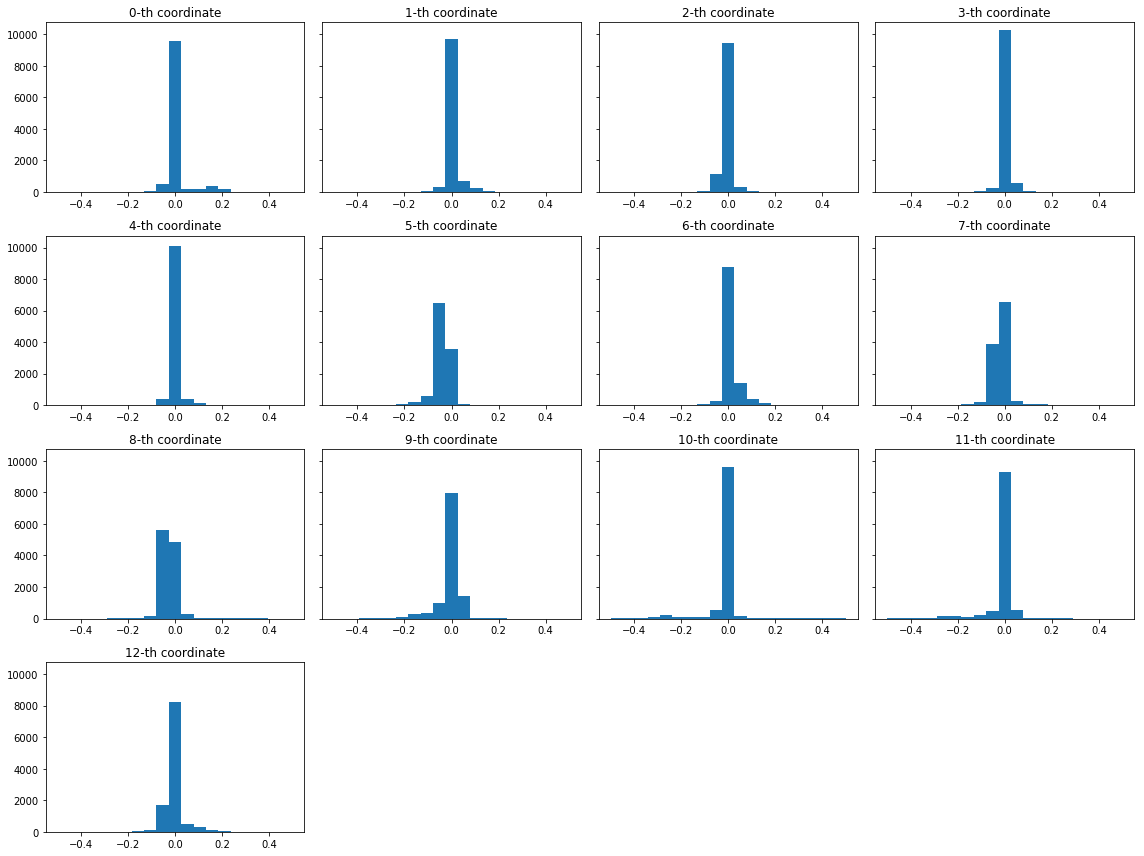

In [5]:
# visualize the histgrams of coordinates of the error vectors
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors.shape[1]:
        ax.remove()
    else:
        ax.hist(error_vectors[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

# Grid search
In this section, we search for optimal window size and the thresholds of likelihood for each size.

In [6]:
# load second normal validation set and the abnormal validation set
val2 = pd.read_csv('../val2_treated.csv', index_col=0)
vala = pd.read_csv('../vala_treated.csv', index_col=0)

In [7]:
# grid search
lookback = 10
memory_widths = [1, 3, 5, 8, 10]

err_avg_n = [[] for i in range(len(memory_widths))]
val2_brokens = getBrokens(val2.index)
for i in range(len(val2_brokens)-1):
    val2X, val2Y = createSequnces(val2.iloc[val2_brokens[i]:val2_brokens[i+1], :], lookback)
    predY = model.predict(np.array(val2X))
    errors = predY - np.array(val2Y)
    llhs = gaussian(np.array(errors))
    for j, memory_width in enumerate(memory_widths):
        err_avg_n[j] += windowAverage(llhs, memory_width)

err_avg_a = [[] for i in range(len(memory_widths))]
vala_broken = getBrokens(vala.index)
for i in range(len(vala_broken)-1):
    valaX, valaY = createSequnces(vala.iloc[vala_broken[i]:vala_broken[i+1], :], lookback)
    if len(valaY) == 0:
        continue
    predY = model.predict(np.array(valaX))
    errors = predY - np.array(valaY)
    llhs = gaussian(np.array(errors))
    for j, memory_width in enumerate(memory_widths):
        err_avg_a[j] += windowAverage(llhs, memory_width)

In [8]:
# calculate precision, recall, f1-score and threshold for each memory width
bm = []
for i, memory_width in enumerate(memory_widths):
    labels = [0 for i in range(len(err_avg_n[i]))] + [1 for i in range(len(err_avg_a[i]))]
    probs = err_avg_n[i] + err_avg_a[i]
    assert len(labels) == len(probs)
    p, r, f1, ts = getOptimalFscore(labels, probs, order='asc', beta=1)
    bm.append( [memory_width, p, r, f1, ts])

bm = pd.DataFrame(bm, columns=['memory_width', 'precision', 'recall', 'f-score', 'threshold'])

In [9]:
# print the benchmark results
bm

,memory_width,precision,recall,f-score,threshold
0,1,0.229167,0.901639,0.365449,3.190959e+06
1,3,0.291667,0.859649,0.435556,2.165606e+06
2,5,0.365672,0.924528,0.524064,5.593668e+06
3,8,0.547619,0.978723,0.702290,3.710106e+06
4,10,0.656716,1.000000,0.792793,3.084912e+06


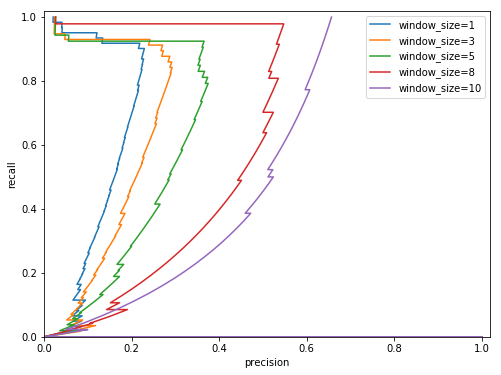

In [10]:
# plot precision-recall curve
plt.figure(figsize=(8, 6))
for i, memory_width in enumerate(memory_widths):
    value_label = np.array([[err, 0] for err in err_avg_n[i]] + [[err, 1] for err in err_avg_a[i]])
    p_trace, r_trace, _ = precision_recall_curve(value_label[:, 1], -value_label[:, 0])
    plt.plot(p_trace, r_trace, label="window_size={}".format(memory_width))
plt.xlabel('precision')
plt.ylabel('recall')
plt.xlim((0,1.02))
plt.ylim((0,1.02))
plt.legend(loc='best')
plt.show()

# Error vectors distribution
In this section, we visulize histograms of all coordinates of the error vectors of the second normal validation set and the abnormal validation set.

## second normal validation dataset

In [11]:
val2X, val2Y = createDataset(val2, lookback)
error_vectors_n = model.predict(val2X) - val2Y

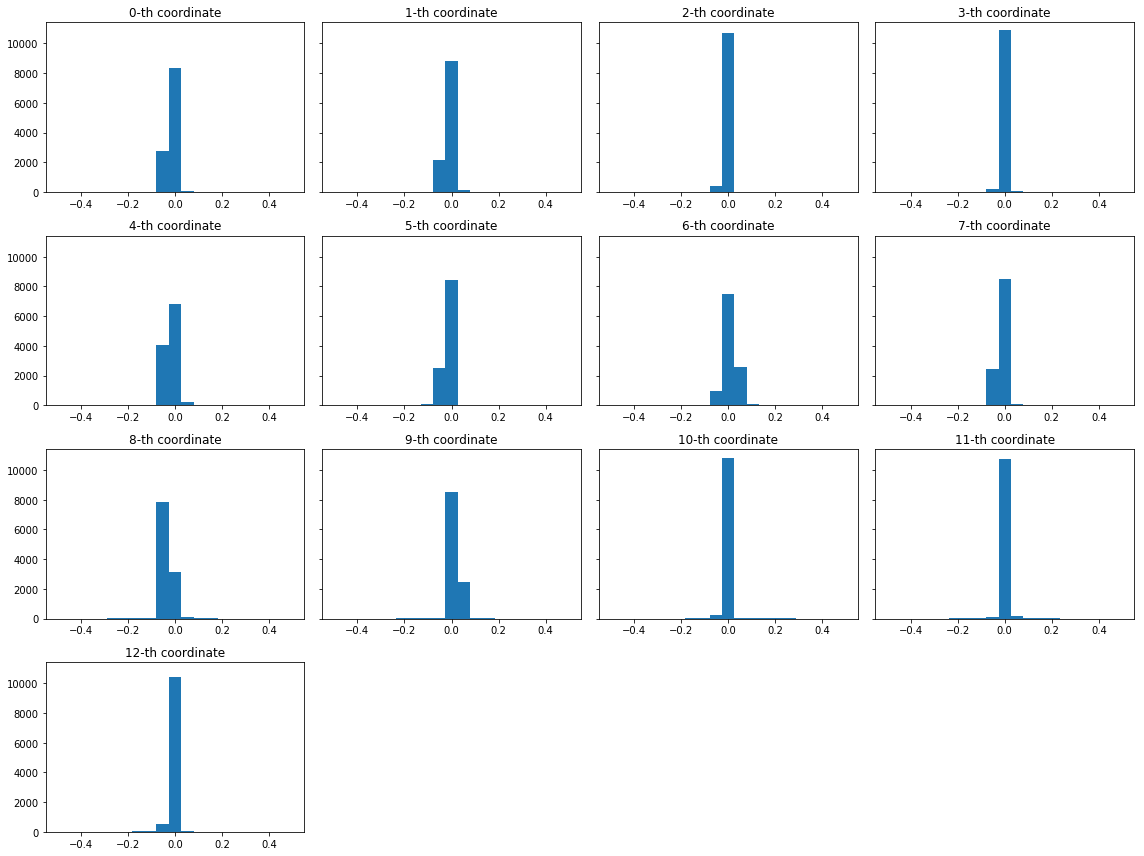

In [12]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors_n.shape[1]:
        ax.remove()
    else:
        ax.hist(error_vectors_n[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

## abnormal validation dataset

In [13]:
error_vectors_a = []
vala_broken = getBrokens(vala.index)
for i in range(len(vala_broken)-1):
    valaX, valaY = createSequnces(vala.iloc[vala_broken[i]:vala_broken[i+1], :], lookback)
    if len(valaY) == 0:
        continue
    predY_a = model.predict(np.array(valaX))
    errors_a = predY_a - np.array(valaY)
    error_vectors_a += list(errors_a)
error_vectors_a = np.array(error_vectors_a)

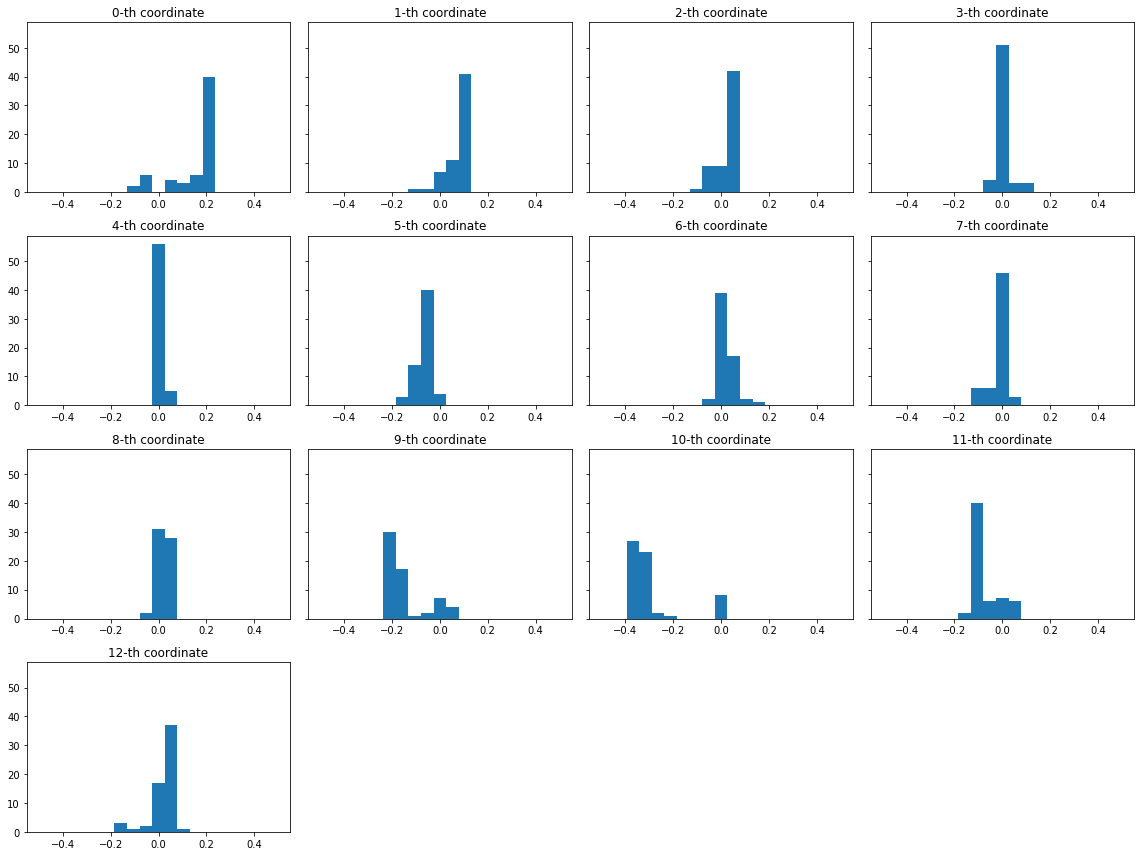

In [14]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors_a.shape[1]:
        ax.remove()
    else:
        ax.hist(error_vectors_a[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

# Testing

In [15]:
testn = pd.read_csv('../testn_treated.csv', index_col=0)
testa = pd.read_csv('../testa_treated.csv', index_col=0)

In [16]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
lookback = 10
memory_widths = [1, 3, 5, 8, 10]

testn = pd.read_csv('../testn_treated.csv', index_col=0)
testa = pd.read_csv('../testa_treated.csv', index_col=0)

bm_test = []
for i, memory_width in enumerate(memory_widths):

    err_avg_test_n = []
    testn_broken = getBrokens(testn.index)
    for i in range(len(testn_broken)-1):
        testnX, testnY = createSequnces(testn.iloc[testn_broken[i]:testn_broken[i+1], :], lookback)
        if len(testnY) == 0:
            continue
        predY_n = model.predict(np.array(testnX))
        errors_n = predY_n - np.array(testnY)
        llhs_n = gaussian(np.array(errors_n))
        err_avg_test_n += windowAverage(llhs_n, memory_width)

    err_avg_test_a = []
    testa_broken = getBrokens(testa.index)
    for i in range(len(testa_broken)-1):
        testaX, testaY = createSequnces(testa.iloc[testa_broken[i]:testa_broken[i+1], :], lookback)
        if len(testaY) == 0:
            continue
        predY_a = model.predict(np.array(testaX))
        errors_a = predY_a - np.array(testaY)
        llhs_a = gaussian(np.array(errors_a))
        err_avg_test_a += windowAverage(llhs_n, memory_width)

    ts = bm.iloc[i, 4]
    value_label_test = np.array([[err, 0, int(err > ts)] for err in err_avg_test_n] + 
                                [[err, 1, int(err > ts)] for err in err_avg_test_a])
    precision, recall, f1, _ = precision_recall_fscore_support(value_label_test[:, 1], 
                                                           value_label_test[:, 2], 
                                                           average='binary')
#     print(precision, recall, f1)
    bm_test.append([memory_width, precision, recall, f1])

bm_test = pd.DataFrame(bm_test, columns=['memory_width', 'precision', 'recall', 'f-score'])

In [17]:
bm_test

,memory_width,precision,recall,f-score
0,1,0.027414,0.844037,0.053102
1,3,0.026331,0.841121,0.051064
2,5,0.025423,0.838095,0.049348
3,8,0.024839,0.852941,0.048273
4,10,0.024460,0.860000,0.047566


# histgram of normal testing dataset

In [18]:
testnX, testnY = createDataset(testn, lookback)
error_testn = model.predict(testnX) - testnY

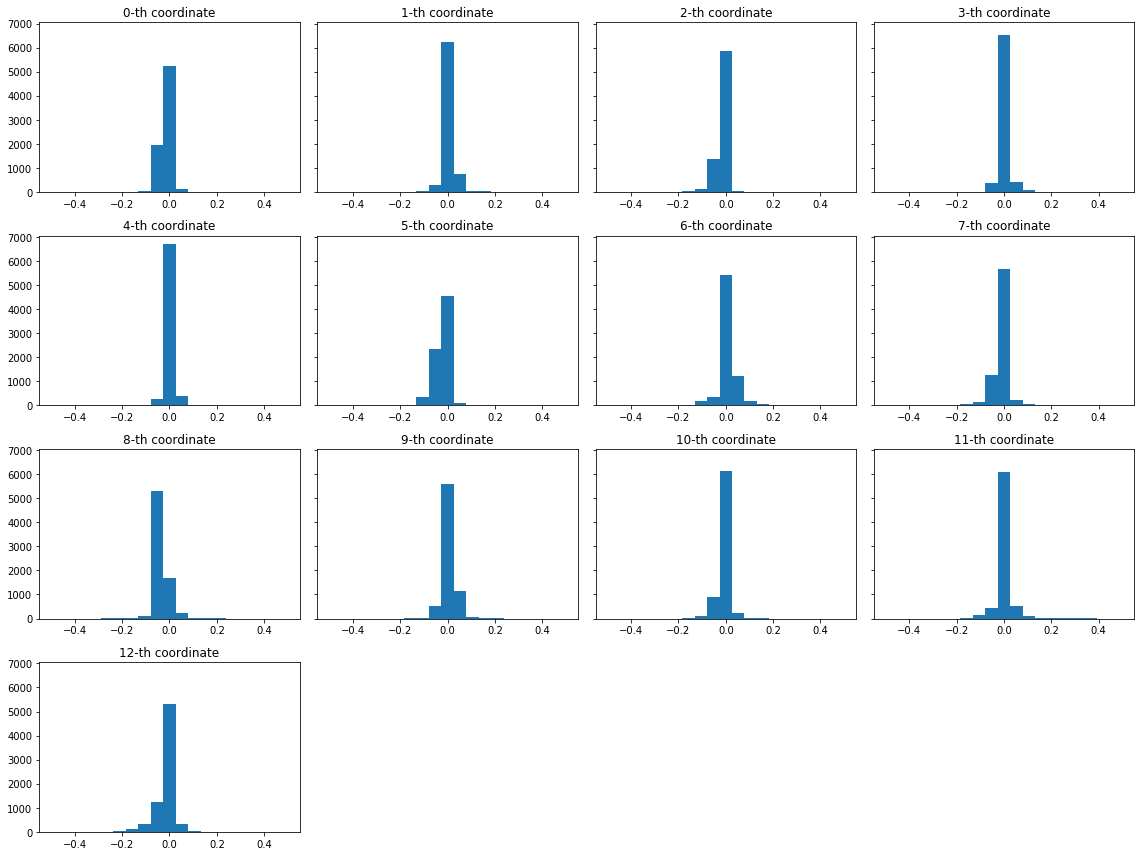

In [19]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_testn.shape[1]:
        ax.remove()
    else:
        ax.hist(error_testn[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()

## histgrams of abnormal testing dataset

In [20]:
error_testa = []
testa_broken = getBrokens(testa.index)
for i in range(len(testa_broken)-1):
    testaX, testaY = createSequnces(testa.iloc[testa_broken[i]:testa_broken[i+1], :], lookback)
    if len(testaY) == 0:
        continue
    predY_a = model.predict(np.array(testaX))
    errors_a = predY_a - np.array(testaY)
    error_testa += list(errors_a)
error_testa = np.array(error_testa)

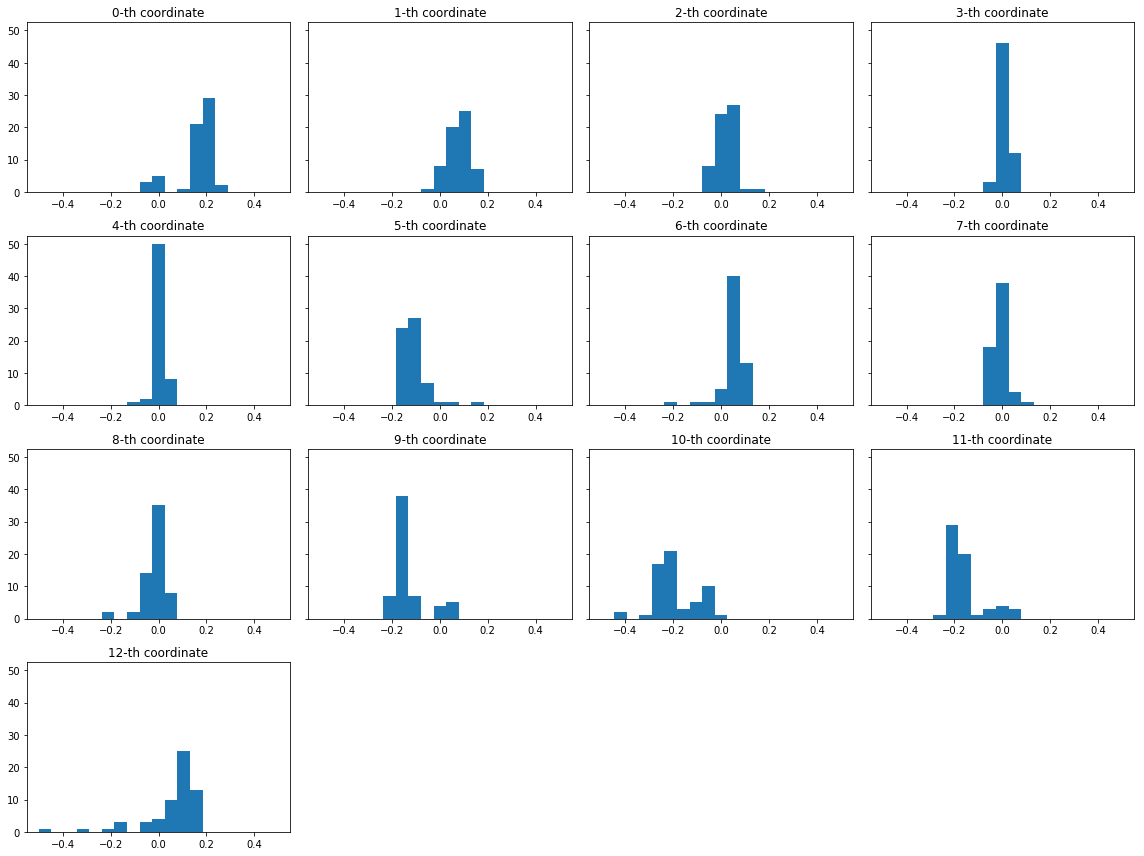

In [21]:
bins = np.linspace(-0.5, 0.5, 20)
fig, axs = plt.subplots(nrows=4, ncols=4, sharey=True, figsize=(16,12))
for i, ax in enumerate(axs.flatten()):
    if i >= error_vectors_a.shape[1]:
        ax.remove()
    else:
        ax.hist(error_testa[:, i], bins)
        ax.set_title('{}-th coordinate'.format(i))
plt.tight_layout()
plt.show()